# SN Fits as Reference

Set of SNooPy fits using all and grJH bands, and Gaussian Process fits of J and H bands (independently).

In [1]:
import snpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import george
import scipy

import os
import glob

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'

SNooPy version: v2.6.0


## Gaussian Process fit functions

In [2]:
def get_parameter(sn, parameter):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    sys_err = sn.systematics()[parameter]
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

def gp_lc_fit(x_data, y_data, yerr_data=0.0, kernel='matern52'):
    """Fits a single light curve with gaussian process.
    
    **Note:** The package ``george`` is used for the gaussian process fit.
    
    Parameters
    =======
    x_data : array
        Independent values.
    y_data : array
        Dependent values.
    yerr_data : array, default ``0.0``
        Dependent value errors.
    kernel : str, default ``matern52``
        Kernel to be used with the gaussian process. E.g.,
        ``matern52``, ``matern32``, ``squaredexp``.
        
    Returns
    =======
    x_pred : array
        Interpolated x-axis values.
    mean : array
        Interpolated  values.
    std : array
        Standard deviation (:math:`1\sigma`) of the interpolation.
    """

    # define the objective function (negative log-likelihood in this case)
    def neg_log_like(params):
        """Negative log-likelihood."""
        gp.set_parameter_vector(params)
        log_like = gp.log_likelihood(y, quiet=True)
        if np.isfinite(log_like):
            return -log_like
        else:
            return np.inf

    # and the gradient of the objective function
    def grad_neg_log_like(params):
        """Gradient of the negative log-likelihood."""
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y, quiet=True)

    x, y, yerr = np.copy(x_data), np.copy(y_data), np.copy(yerr_data)

    x_min, x_max = x.min(), x.max()

    y_norm = y.max()
    y /= y_norm
    yerr /= y_norm

    var, length_scale = np.var(y), np.diff(x).max()

    k1 = george.kernels.ConstantKernel(np.log(var))

    if kernel == 'matern52':
        k2 = george.kernels.Matern52Kernel(length_scale**2)
    elif kernel == 'matern32':
        k2 = george.kernels.Matern32Kernel(length_scale**2)
    elif kernel == 'squaredexp':
        k2 = george.kernels.ExpSquaredKernel(length_scale**2)
    else:
        raise ValueError(f'"{kernel}" is not a valid kernel.')

    ker = k1*k2

    gp = george.GP(kernel=ker, fit_mean=True)
    # initial guess
    gp.compute(x, yerr)

    # optimization routine for hyperparameters
    p0 = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    results = scipy.optimize.minimize(neg_log_like, p0, jac=grad_neg_log_like,
                                            method="L-BFGS-B", options={'maxiter':30})
    gp.set_parameter_vector(results.x)

    step = 0.1
    x_pred = np.arange(x_min-10, x_max+step+10, step)

    mean, var = gp.predict(y, x_pred, return_var=True)
    std = np.sqrt(var)

    mean, std = mean*y_norm, std*y_norm

    return x_pred, mean, std

def gp_fit(sn):
    """Fits the NIR light curves of a SN with Gaussian Process.
    
    **Note:** if the SN contains J and Jrc2 bands, these are
    joined and treated as one for the GP fit.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    sn object.
    """
        
    sn.choose_model(SNOOPY_MODEL)
    
    NIR_bands = ['J', 'Jrc2', 'H']
    bands = [band for band in sn.allbands() if band in NIR_bands]
    
    for band in bands:
        # SNooPy GP fit for plotting reference only
        sn.data[band].curve_fit(method='gp')
        
        if (band=='Jrc2') & ('J' in bands):
            continue  # skip this bands
            
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        # check if the SN has J and Jrc2 bands and join them
        if (band=='J') & ('Jrc2' in bands):
            data_Jrc2 = sn.data['Jrc2']
            mjd_Jrc2  = data_Jrc2.MJD
            mag_Jrc2, mag_err_Jrc2 = data_Jrc2.magnitude, data_Jrc2.e_mag
            
            mjd = np.r_[mjd, mjd_Jrc2]
            mag = np.r_[mag, mag_Jrc2]
            mag_err = np.r_[mag_err, mag_err_Jrc2]
        
        gp_mjd, gp_mag, gp_mag_err = gp_lc_fit(mjd, mag, mag_err)
        imax = np.argmin(gp_mag)  # index of peak mag
        
        # save values
        sn.data[band].gp_mjd = gp_mjd
        sn.data[band].gp_mag = gp_mag
        sn.data[band].gp_mag_err = gp_mag_err
        sn.data[band].gp_max = gp_mag[imax]
        sn.data[band].gp_max_err = gp_mag_err[imax]
            
    # save object and plot
    sn.save(f'fits/{sn.name}_gp.snpy')
    sn.plot(outfile=f'fits/{sn.name}_gp.jpeg')
    
    return sn

## SNooPy fit functions

In [3]:
def grJH_fit(sn):
    """Fits grJH-bands light curves of a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    
    grJH_bands = ['g', 'r', 'J', 'Jrc2', 'H']
    bands = [band for band in sn.allbands() if band in grJH_bands]
    
    sn.choose_model(SNOOPY_MODEL)
    sn.fit(bands)
    
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    sn.grJH_Tmax = Tmax
    sn.grJH_Tmax_err = Tmax_err
    
    for band in bands:
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        model_mjd = np.arange(mjd.min()-10, mjd.max()+10, 0.1)
        model_mag, model_mag_err, _ = sn.model(band, model_mjd)
        
        # skip Jrc2 if J is present as they overlap
        if (band=='Jrc2') & ('J' in bands):
            continue
        # otherwise, use Jrc2 if J is not present
        elif (band=='Jrc2') & ('J' not in bands):
            mmax, mmax_err = get_parameter(sn, 'Jmax')
        else:
            mmax, mmax_err = get_parameter(sn, band+'max')
        
        # save values
        sn.data[band].grJH_mjd = model_mjd
        sn.data[band].grJH_mag = model_mag
        sn.data[band].grJH_mag_err = model_mag_err
        sn.data[band].grJH_max = mmax
        sn.data[band].grJH_max_err = mmax_err
        
    # save object and plot
    sn.save(f'fits/{sn.name}_grJH.snpy')
    sn.plot(outfile=f'fits/{sn.name}_grJH.jpeg')
    
    return sn

def AllBands_fit(sn):
    """Fits ALL the light curves of a SN with SNooPy.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.

    Returns
    =======
    sn object.
    """
    
    sn.choose_model(SNOOPY_MODEL)
    sn.fit()
    
    Tmax, Tmax_err = get_parameter(sn, 'Tmax')
    sn.AllBands_Tmax = Tmax
    sn.AllBands_Tmax_err = Tmax_err
    
    bands = sn.allbands()
    
    for band in bands:
        data = sn.data[band]
        mjd, mag, mag_err = data.MJD, data.magnitude, data.e_mag
        
        model_mjd = np.arange(mjd.min()-10, mjd.max()+10, 0.1)
        model_mag, model_mag_err, _ = sn.model(band, model_mjd)
        
        # skip Jrc2 if J is present as they overlap
        if (band=='Jrc2') & ('J' in bands):
            continue
        # otherwise, use Jrc2 if J is not present
        elif (band=='Jrc2') & ('J' not in bands):
            mmax, mmax_err = get_parameter(sn, 'Jmax')
            
        # similar thing for V bands
        elif (band=='V0') & ('V' in bands):
            continue
        elif (band=='V0') & ('V' not in bands):
            mmax, mmax_err = get_parameter(sn, 'Vmax')
            
        # ... and for Y bands
        elif (band=='Ydw') & ('Y' in bands):
            continue
        elif (band=='Ydw') & ('Y' not in bands):
            mmax, mmax_err = get_parameter(sn, 'Ymax')
        else:
            mmax, mmax_err = get_parameter(sn, band+'max')
        
        # save values
        sn.data[band].allbands_mjd = model_mjd
        sn.data[band].allbands_mag = model_mag
        sn.data[band].allbands_mag_err = model_mag_err
        sn.data[band].allbands_max = mmax
        sn.data[band].allbands_max_err = mmax_err
        
    # save object and plot
    sn.save(f'fits/{sn.name}_AllBands.snpy')
    sn.plot(outfile=f'fits/{sn.name}_AllBands.jpeg')
    
    return sn

## Results-saving functions

In [4]:
def save_results(sn):
    """Save the results of the fits of a SN after using
    `gp_fit`, `grJH_fit` and `AllBands_fit`.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    """
    
    results_dict = {'name':sn.name,
                    'Tmax_AllBands':sn.AllBands_Tmax,
                    'Tmax_err_AllBands':sn.AllBands_Tmax_err,
                    'Tmax_grJH':sn.grJH_Tmax,
                    'Tmax_err_grJH':sn.grJH_Tmax_err,
                   }
    
    JH_bands = ['J', 'Jrc2', 'H']
    bands = [band for band in sn.allbands() if band in JH_bands]
    
    for band in bands:
        mmax_dict = {}
        
        # skip Jrc2 if J is present
        if (band=='Jrc2') & ('J' in bands):
            continue
            
        filt = band[0]  # either J or H
        mmax_dict = {f'{filt}max_gp':sn.data[band].gp_max,
                     f'{filt}max_err_gp':sn.data[band].gp_max_err,
                     f'{filt}max_grJH':sn.data[band].grJH_max,
                     f'{filt}max_err_grJH':sn.data[band].grJH_max_err,
                     f'{filt}max_AllBands':sn.data[band].allbands_max,
                     f'{filt}max_err_AllBands':sn.data[band].allbands_max_err,
        }
        
        results_dict.update(mmax_dict)
        
    return results_dict

def full_fit(sn):
    """Fits a SN with `gp_fit`, `grJH_fit` and `AllBands_fit`.
    The combined results are saved in a single snpy file.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Results
    =======
    sn_df: pandas DataFrame
        Dataframe with the results of the SN, e.g.,
        Tmax, Jmax, Hmax, for the different fits 
    """
    
    sn = gp_fit(sn)
    sn = grJH_fit(sn)
    sn = AllBands_fit(sn)
    sn.save(f'fits/{sn.name}.snpy')
    
    results_dict = save_results(sn)
    sn_df = pd.DataFrame(results_dict, index=[0])
    
    return sn_df

### Fit multiple SNe

Fitting 40 SNe (94 from 134 CSP SNe removed using cuts)
Warning!  0.000000% of MC realizations had good dm15
Warning!  65.000000% of MC realizations had good Tmax
Warning!  65.000000% of MC realizations had good Mmax
Warning!  65.000000% of MC realizations had good dm15
Warning!  0.000000% of MC realizations had good dm15
Warning!  6.000000% of MC realizations had good dm15
Warning!  74.000000% of MC realizations had good Tmax
Warning!  74.000000% of MC realizations had good Mmax
Warning!  74.000000% of MC realizations had good dm15
Warning!  0.000000% of MC realizations had good dm15
Warning!  38.000000% of MC realizations had good Tmax
Warning!  38.000000% of MC realizations had good Mmax
Warning!  38.000000% of MC realizations had good dm15
Warning!  53.000000% of MC realizations had good Tmax
Warning!  53.000000% of MC realizations had good Mmax
Warning!  53.000000% of MC realizations had good dm15
Warning!  33.000000% of MC realizations had good Tmax
Warning!  33.000000% of MC rea

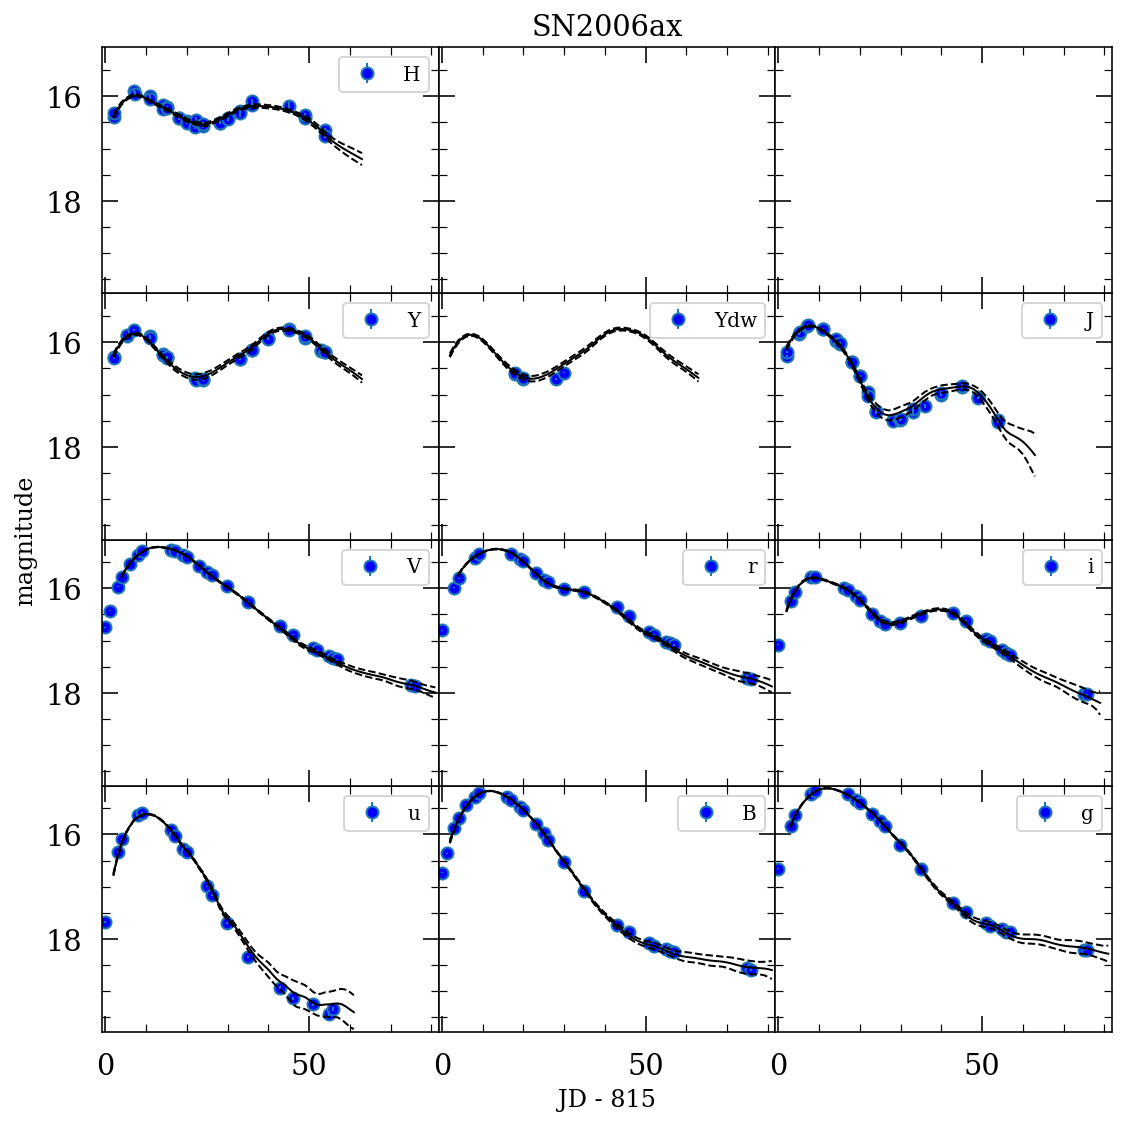

In [5]:
# SNe to remove
df1 = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
df2 = pd.read_csv('sne_wo_opt_max.txt', names=['name', 'comment'], delim_whitespace=True)
df3 = pd.read_csv('sne_wo_nir_max.txt', names=['name', 'comment'], delim_whitespace=True)
del_df = pd.concat([df1, df2, df3])
files2remove = [f'csp_dr3/{name}_snpy.txt' for name in list(del_df.name.values)]

sn_files = [file for file in glob.glob('csp_dr3/*.txt') if file not in files2remove]
print(f'Fitting {len(sn_files)} SNe ({len(files2remove)} from 134 CSP SNe removed using cuts)')

df_list = []
for sn_file in sn_files:
    sn = snpy.import_lc(sn_file)

    try:
        sn_df = full_fit(sn)
        df_list.append(sn_df)
    except:
        print(f'Unable to fit {sn.name}')
        
master_df = pd.concat(df_list, ignore_index=True)
master_df.to_csv('reference_result.txt', index=False)

### Fit a single SN

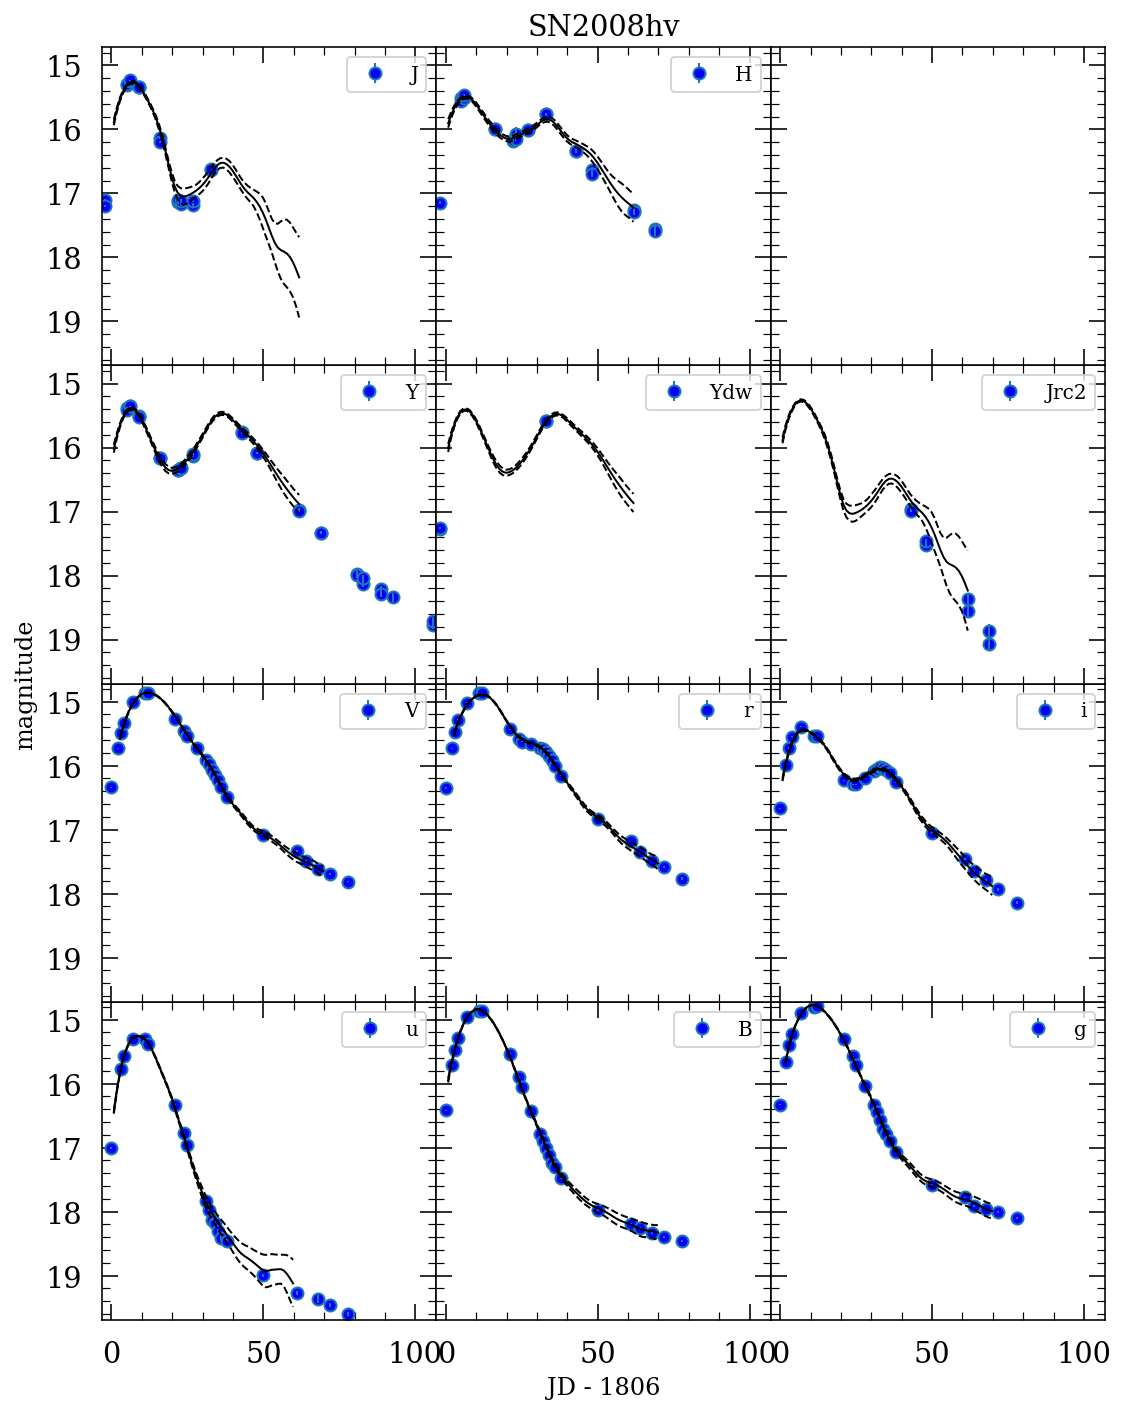

In [25]:
sn_name = 'SN2008hv'
sn_file = os.path.join('csp_dr3', f'{sn_name}_snpy.txt')

sn = snpy.import_lc(sn_file)
sn_df = full_fit(sn)